In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(200, latent_dim)
        self.fc_logvar = nn.Linear(200, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Load your DataFrame with suitable numerical data
# Replace 'your_data.csv' with the path to your CSV file
data = pd.read_csv('C:\\Users\james\Downloads\AK_data_labeled.csv')

# Delete columns 0 to 8 Non numeric data
columns_to_delete = data.columns[0:8]
data.drop(columns=columns_to_delete, inplace=True)

# Convert the DataFrame to a PyTorch tensor
data_tensor = torch.Tensor(data.values)

# Split the data into training and test sets
train_data, test_data = train_test_split(data_tensor, test_size=0.2, random_state=42)

# Initialize VAE
input_dim = data.shape[1]
latent_dim = 2  # You can adjust the latent dimension
vae = VAE(input_dim, latent_dim)

# Define a DataLoader for training data
batch_size = 128
train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)

# Train the VAE
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, batch_data in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(batch_data[0])
        loss = loss_function(recon_batch, batch_data[0], mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'====> Epoch: {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

# Train for 20 epochs
for epoch in range(1, 50):
    train(epoch)

# Reconstruct the test data
with torch.no_grad():
    reconstructed_data = vae.decode(vae.encode(test_data)[0])



====> Epoch: 1, Loss: 3262.721730245232
====> Epoch: 2, Loss: 3041.149778610354
====> Epoch: 3, Loss: 2968.5841094388625
====> Epoch: 4, Loss: 2942.9000340599455
====> Epoch: 5, Loss: 2929.800254385218
====> Epoch: 6, Loss: 2921.221623807902
====> Epoch: 7, Loss: 2916.535736333447
====> Epoch: 8, Loss: 2912.2105117506812
====> Epoch: 9, Loss: 2908.003097326294
====> Epoch: 10, Loss: 2904.721528014305
====> Epoch: 11, Loss: 2901.221363036444
====> Epoch: 12, Loss: 2898.4228222922343
====> Epoch: 13, Loss: 2896.0496796236375
====> Epoch: 14, Loss: 2894.2473603542235
====> Epoch: 15, Loss: 2891.9440299301773
====> Epoch: 16, Loss: 2890.420140071526
====> Epoch: 17, Loss: 2889.204529972752
====> Epoch: 18, Loss: 2887.3298333191415
====> Epoch: 19, Loss: 2885.6152609843325
====> Epoch: 20, Loss: 2883.9046534400545
====> Epoch: 21, Loss: 2880.758456445845
====> Epoch: 22, Loss: 2878.3627064884195
====> Epoch: 23, Loss: 2877.3208446866483
====> Epoch: 24, Loss: 2876.1198910081744
====> Epoch:

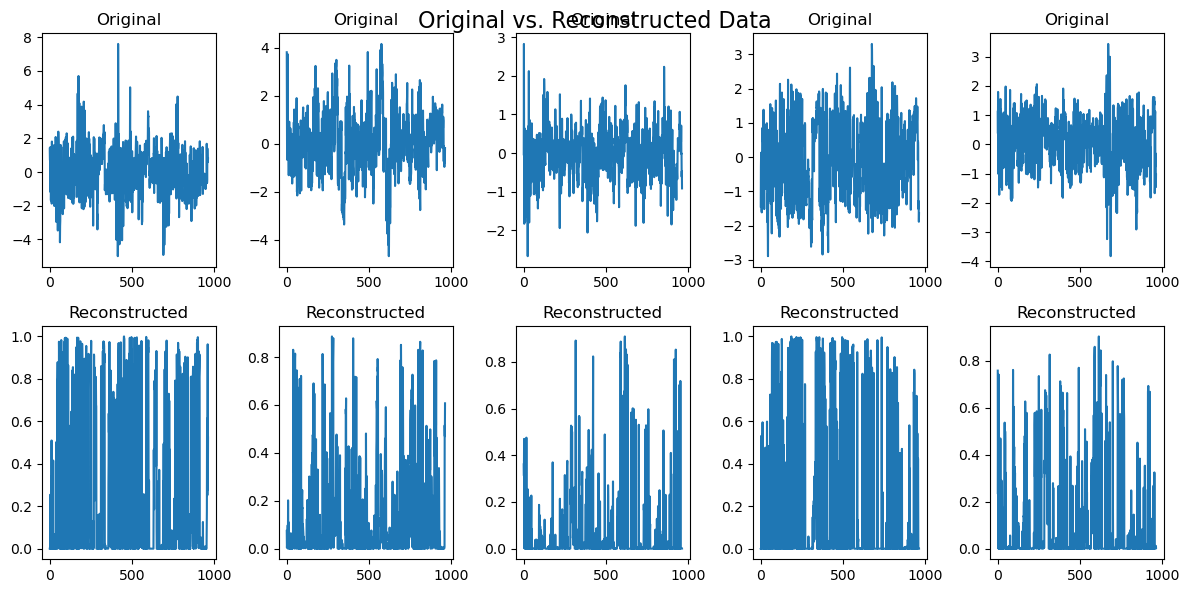

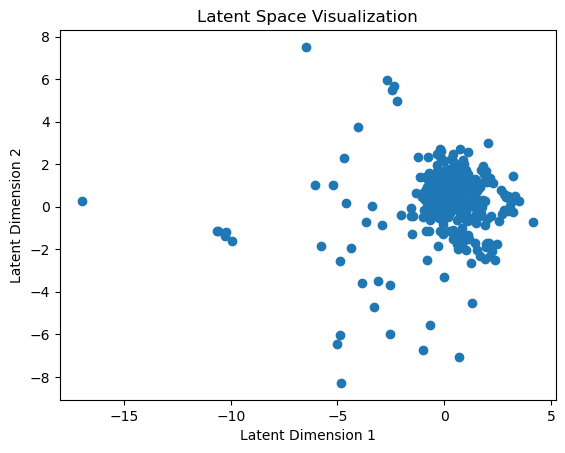

In [14]:
# Visualize the original and reconstructed data
n_samples = 5  # Number of samples to visualize
sample_indices = np.random.choice(len(test_data), n_samples, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(sample_indices):
    plt.subplot(2, n_samples, i + 1)
    plt.plot(test_data[idx].numpy())
    plt.title('Original')

    plt.subplot(2, n_samples, n_samples + i + 1)
    plt.plot(reconstructed_data[idx].numpy())
    plt.title('Reconstructed')

plt.tight_layout()
plt.suptitle('Original vs. Reconstructed Data', fontsize=16)
plt.show()


# Visualize the latent space (assuming latent_dim = 2)
encoded_data, _ = vae.encode(test_data)
encoded_data = encoded_data.detach().numpy()  # Detach and convert to NumPy

plt.figure()
plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()